# DAY50

现在我们思考下，是否可以对于预训练模型增加模块来优化其效果，这里我们会遇到一个问题

预训练模型的结构和权重是固定的，如果修改其中的模型结构，是否会大幅影响其性能。其次是训练的时候如何训练才可以更好的避免破坏原有的特征提取器的参数。

所以今天的内容，我们需要回答2个问题。

1. resnet18中如何插入cbam模块？
2. 采用什么样的预训练策略，能够更好的提高效率？





可以很明显的想到，如果是resnet18+cbam模块，那么大多数地方的代码都是可以复用的，模型定义部分需要重写。先继续之前的代码





所以很容易的想到之前第一次使用resnet的预训练策略：先冻结预训练层，然后训练其他层。之前的其它层是全连接层（分类头），现在其它层还包含了每一个残差块中的cbam注意力层。

## resnet结构解析

先复用下数据预处理+定义cbam的代码，然后看下resnet内部的结构是什么，这决定我们如何插入模块


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 定义通道注意力
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        """
        通道注意力机制初始化
        参数:
            in_channels: 输入特征图的通道数
            ratio: 降维比例，用于减少参数量，默认为16
        """
        super().__init__()
        # 全局平均池化，将每个通道的特征图压缩为1x1，保留通道间的平均值信息
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # 全局最大池化，将每个通道的特征图压缩为1x1，保留通道间的最显著特征
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        # 共享全连接层，用于学习通道间的关系
        # 先降维（除以ratio），再通过ReLU激活，最后升维回原始通道数
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),  # 降维层
            nn.ReLU(),  # 非线性激活函数
            nn.Linear(in_channels // ratio, in_channels, bias=False)   # 升维层
        )
        # Sigmoid函数将输出映射到0-1之间，作为各通道的权重
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        前向传播函数
        参数:
            x: 输入特征图，形状为 [batch_size, channels, height, width]
        返回:
            调整后的特征图，通道权重已应用
        """
        # 获取输入特征图的维度信息，这是一种元组的解包写法
        b, c, h, w = x.shape
        # 对平均池化结果进行处理：展平后通过全连接网络
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        # 对最大池化结果进行处理：展平后通过全连接网络
        max_out = self.fc(self.max_pool(x).view(b, c))
        # 将平均池化和最大池化的结果相加并通过sigmoid函数得到通道权重
        attention = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        # 将注意力权重与原始特征相乘，增强重要通道，抑制不重要通道
        return x * attention #这个运算是pytorch的广播机制

## 空间注意力模块
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 通道维度池化
        avg_out = torch.mean(x, dim=1, keepdim=True)  # 平均池化：(B,1,H,W)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # 最大池化：(B,1,H,W)
        pool_out = torch.cat([avg_out, max_out], dim=1)  # 拼接：(B,2,H,W)
        attention = self.conv(pool_out)  # 卷积提取空间特征
        return x * self.sigmoid(attention)  # 特征与空间权重相乘

## CBAM模块
class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attn = ChannelAttention(in_channels, ratio)
        self.spatial_attn = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x
    

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体支持
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 数据预处理（与原代码一致）
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载数据集（与原代码一致）
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

使用设备: cuda
Files already downloaded and verified


先通过预训练resnet18来查看模型结构

In [2]:
import torch
import torchvision.models as models
from torchinfo import summary #之前的内容说了，推荐用他来可视化模型结构，信息最全

# 加载 ResNet18（预训练）
model = models.resnet18(pretrained=True)
model.eval()

# 输出模型结构和参数概要
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│


经典的 ResNet-18 模型可以将其看作一个处理流水线，图像数据从一端进去，分类结果从另一端出来。整个过程可以分为三个主要部分：


| 阶段 (Stage)     | 对应层级 (Layers)                                  | 主要作用                                                                                             |
| :--------------- | :------------------------------------------------- | :--------------------------------------------------------------------------------------------------- |
| **1. 输入预处理 (Stem)** | `Conv2d: 1-1` 到 `MaxPool2d: 1-4`                  | 对输入图像进行初步的特征提取，并通过池化操作将特征图尺寸减半，为后续处理做准备。                   |
| **2. 核心特征提取**  | 四个 `Sequential` 模块 (`1-5` 到 `1-8`)              | 这是网络的主体，由多个残差块（`BasicBlock`）堆叠而成，负责从浅到深、从粗到细地学习图像特征。 |
| **3. 分类输出 (Head)**   | `AdaptiveAvgPool2d: 1-9` 和 `Linear: 1-10` | 将最终的特征图（feature map）转换成一个特征向量，并通过全连接层映射到最终的 1000 个类别上。  |

假设输入图像尺寸为 `[1, 3, 224, 224]` (Batch, Channels, Height, Width)，具体shape变化如下

| 阶段 / 层级                                 | 输出尺寸             | 通道数变化        | 尺寸变化                  | 关键操作和说明                                                                                        |
| :------------------------------------------ | :------------------- | :---------------- | :------------------------ | :---------------------------------------------------------------------------------------------------- |
| **输入**                                    | `[1, 3, 224, 224]`   | -                 | -                         | 初始输入图像。                                                                                        |
| **1. 输入预处理 (Stem)**                      |                      |                   |                           |                                                                                                       |
| `Conv2d: 1-1` (7x7, stride=2)               | `[1, 64, 112, 112]`  | `3 -> 64`         | `224x224 -> 112x112`      | 大卷积核快速提取初始特征，步长为2使尺寸减半。                                                       |
| `MaxPool2d: 1-4` (3x3, stride=2)            | `[1, 64, 56, 56]`    | 不变              | `112x112 -> 56x56`        | 再次进行池化，进一步减小尺寸，减少计算量。                                                          |
| **2. 核心特征提取**                         |                      |                   |                           |                                                                                                       |
| **Stage 1** (`Sequential: 1-5`, 2个BasicBlock) | `[1, 64, 56, 56]`    | 不变 (`64 -> 64`)   | 不变 (`56x56`)              | 包含2个标准的`BasicBlock`，深化特征，但保持尺寸和通道数不变。                                     |
| **Stage 2** (`Sequential: 1-6`, 2个BasicBlock) | `[1, 128, 28, 28]`   | `64 -> 128`       | `56x56 -> 28x28`          | **尺寸减半，通道加倍**。第一个`BasicBlock` (2-3) 负责这个转换（这种块也叫 "downsampling block"）。 |
| **Stage 3** (`Sequential: 1-7`, 2个BasicBlock) | `[1, 256, 14, 14]`   | `128 -> 256`      | `28x28 -> 14x14`          | **尺寸减半，通道加倍**。同样由该阶段的第一个`BasicBlock` (2-5) 完成。                                |
| **Stage 4** (`Sequential: 1-8`, 2个BasicBlock) | `[1, 512, 7, 7]`     | `256 -> 512`      | `14x14 -> 7x7`            | **尺寸减半，通道加倍**。由该阶段的第一个`BasicBlock` (2-7) 完成。                                     |
| **3. 分类输出 (Head)**                      |                      |                   |                           |                                                                                                       |
| `AdaptiveAvgPool2d: 1-9`                    | `[1, 512, 1, 1]`     | 不变              | `7x7 -> 1x1`              | 全局平均池化，将每个通道的 `7x7` 特征图压缩成一个值，得到一个长度为 512 的特征向量。                  |
| `Linear: 1-10`                              | `[1, 1000]`          | `512 -> 1000`     | -                         | 全连接层，将 512 维的特征向量映射到 1000 个类别得分上。                                               |


这里我们先介绍下basic block，他是残差网络最重要的思想，在 ResNet 出现之前，人们普遍认为神经网络越深，性能就越好。但实践发现，当网络堆叠到一定深度后，再增加层数，模型的准确率反而会下降。这种现象不叫“过拟合”（Overfitting），因为不光是测试集，连训练集上的准确率都在下降。这被称为 “网络退化”（Degradation） 问题。

本质是因为卷积和池化都是在做下采样的过程，越深虽然能够提取越重要的信息，但是很多重要的信息都被丢弃了。它意味着，让一个很深的网络去学习一个简单的恒等变换（即 输出 = 输入）都非常困难。

BasicBlock 的设计者何恺明博士等人提出了一个绝妙的想法：与其让网络层直接学习一个目标映射 H(x)，不如让它学习这个映射与输入 x 之间的“差值”，即残差（Residual）F(x) = H(x) - x。这样，原始的目标映射就变成了 H(x) = F(x) + x

这个简单的改动为什么如此强大？

- 简化学习目标：想象一个极端情况，如果某一层的最佳状态就是“什么都不做”（即恒等变换 H(x)=x），那么网络只需要让残差部分 F(x) 的输出为 0 即可。让权重趋向于 0 比让一堆非线性层拟合一个恒等变换要容易得多。

- 信息高速公路： + x 这部分操作被称为“快捷连接”（Shortcut Connection）或“跳跃连接”（Skip Connection）。它像一条高速公路，允许输入信息 x 直接“跳”到更深的层，避免了在层层传递中信息丢失或梯度消失的问题。

一个标准的 BasicBlock 通常包含两条路径

1. 主路 (Main Path)：这是学习“残差” F(x) 的部分。在 ResNet-18 中，它由两个 3x3 的卷积层构成。
Conv2d: 3-1 (3x3 卷积)-->BatchNorm2d: 3-2 (批归一化)-->ReLU: 3-3 (激活函数)-->Conv2d: 3-4 (3x3 卷积)-->BatchNorm2d: 3-5 (批归一化)

2. 捷径 (Shortcut Path)：这就是 + x 的部分，直接将输入 x 传递过来。

最后，将主路的输出和捷径的输出按元素相加，再经过一个 ReLU 激活函数，得到整个 BasicBlock 的最终输出。

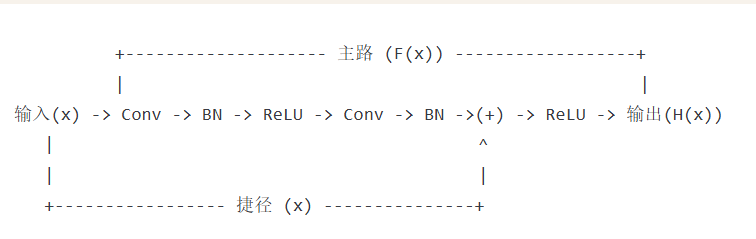

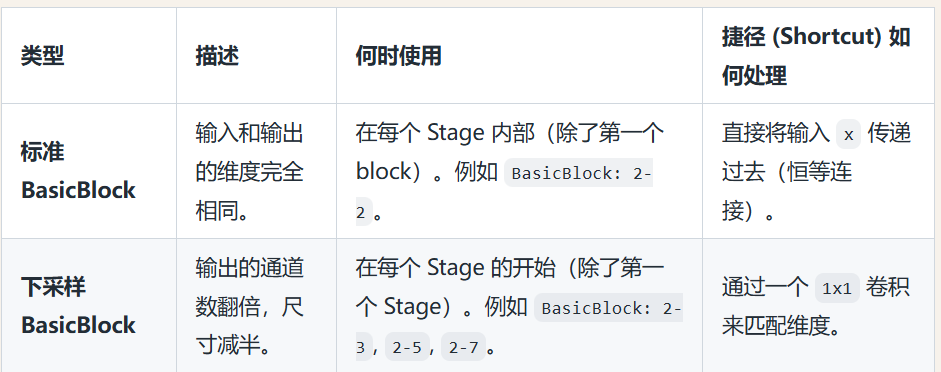

## cbam的放置位置

我们知道，加载预训练模型的时候，需要加载好预训练的模型架构，然后加载预训练的权重。如果修改模型的架构，比如在中间插入某个模块或层，很可能导致他后续预训练的权重失效。那么如何解决这个问题呢？

一种很容易被想到的思想是：cbam可以放置在全连接层之前，这是最简单的想法。保留了原始的信息。可以理解为在模型做出最终分类决策之前，对提取到的最高阶特征图做一次最后的“精炼”和“校准”。

但是这么做有一个弊端，注意力机制只在最后起作用，无法帮助网络在中间层构建出更好的、带有注意力信息的特征。前面的所有卷积块依然是“盲目”地提取特征。这就像一个学生直到做完整张试卷才开始划重点，而不是每做完一道题就总结一次。

但是你要注意，最后的卷积形式是 卷积--激活--池化--全连接，如果你放置前全连接前的话，cbam中的空间注意力会完全失效，因为此时空间维度不存在了，失去了寻找空间相关性的能力。只留下通道注意力仍然在作用。


实际上，被公认为正确的做法是，在每一个残差块的输出上应用CBAM注意力。你可能会想，这样不是会影响后续的输出，尤其最开始注意力权重交叉的话，很可能导致后续预训练层的权重没有价值了。

实际，CBAM模块自身的结构——初始状态接近“直通”，这是最核心的技术原因导致可以采用这个结构。CBAM模块的最终操作是：return x * self.sigmoid(attention)。这里的 x 是原始特征；attention 是学到的注意力图。

1. 初始状态分析：在一个模块被随机初始化（还未开始训练）时，其内部的卷积层和全连接层的权重都非常小，接近于0。因此，计算出的 attention 图的值也都会非常接近0。
2. Sigmoid函数的特性：当输入为0时，sigmoid(0) 的输出是 0.5。这意味着在训练刚开始的第一步，CBAM模块的操作近似于 x * 0.5。它并没有用一个完全随机的、混乱的特征图去替换原始特征 x。它只是将原始特征 x 按比例缩小了一半。

缩小0.5只是对特征数值尺度的缩放，它完整地保留了原始特征图中的空间结构和相对关系。下游的预训练层接收到的不再是“垃圾”，而是一个信号稍弱但结构完好的原始特征。这为后续的学习提供了一个非常稳定的起点。

如果CBAM无用：网络可以通过学习，让 attention 图的值都趋近于一个常数，相当于一个固定的缩放。在更理想的情况下，如果能让 attention 图的值都趋近于 sigmoid 函数的反函数中对应输出为1的值，那么CBAM就近似于一个“直通车”(x * 1 = x)，网络可以选择“忽略”它。

如果CBAM有用：网络会迅速学会调整权重，让 attention 图中重要的地方值接近1，不重要的地方值接近0，从而实现特征的增强。

所以完全可以在不破坏其核心结构的情况下，将CBAM模块无缝地“注入”到预训练的ResNet中。这样做的逻辑是：

1. 保留原始结构：原始的残差块负责提取核心特征。
2. 增强特征：紧随其后的CBAM模块对这些提取出的特征进行“精炼”，告诉模型应该“关注什么”（what - 通道注意力）和“在哪里关注”（where - 空间注意力）。
3. 不破坏预训练权重：原始残差块的预训练权重得以完整保留，我们只是在其后增加了一个新的、需要从头学习的模块。


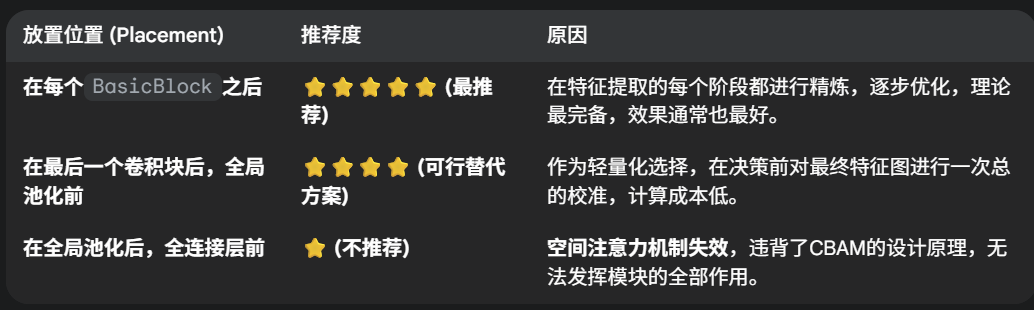








In [11]:
import torch
import torch.nn as nn
from torchvision import models

# 自定义ResNet18模型，插入CBAM模块
class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=10, pretrained=True, cbam_ratio=16, cbam_kernel=7):
        super().__init__()
        # 加载预训练ResNet18
        self.backbone = models.resnet18(pretrained=pretrained) 
        
        # 修改首层卷积以适应32x32输入（CIFAR10）
        self.backbone.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.backbone.maxpool = nn.Identity()  # 移除原始MaxPool层（因输入尺寸小）
        
        # 在每个残差块组后添加CBAM模块
        self.cbam_layer1 = CBAM(in_channels=64, ratio=cbam_ratio, kernel_size=cbam_kernel)
        self.cbam_layer2 = CBAM(in_channels=128, ratio=cbam_ratio, kernel_size=cbam_kernel)
        self.cbam_layer3 = CBAM(in_channels=256, ratio=cbam_ratio, kernel_size=cbam_kernel)
        self.cbam_layer4 = CBAM(in_channels=512, ratio=cbam_ratio, kernel_size=cbam_kernel)
        
        # 修改分类头
        self.backbone.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        # 主干特征提取
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)  # [B, 64, 32, 32]
        
        # 第一层残差块 + CBAM
        x = self.backbone.layer1(x)  # [B, 64, 32, 32]
        x = self.cbam_layer1(x)
        
        # 第二层残差块 + CBAM
        x = self.backbone.layer2(x)  # [B, 128, 16, 16]
        x = self.cbam_layer2(x)
        
        # 第三层残差块 + CBAM
        x = self.backbone.layer3(x)  # [B, 256, 8, 8]
        x = self.cbam_layer3(x)
        
        # 第四层残差块 + CBAM
        x = self.backbone.layer4(x)  # [B, 512, 4, 4]
        x = self.cbam_layer4(x)
        
        # 全局平均池化 + 分类
        x = self.backbone.avgpool(x)  # [B, 512, 1, 1]
        x = torch.flatten(x, 1)  # [B, 512]
        x = self.backbone.fc(x)  # [B, 10]
        return x
    
# 初始化模型并移至设备
model = ResNet18_CBAM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

## 训练策略

差异化学习率

预训练层（ResNet部分）：他们是经验丰富的资深专家。他们已经很懂得如何处理特征，不需要大的改动。
新模块（CBAM和分类头）：他们是刚入职的实习生，一张白纸，需要快速学习。
你的训练策略（优化器）就像是CEO，你会这样分配任务：

给实习生（新模块） 设置一个较高的学习率（比如1e-3），让他们快速试错，快速成长。
给专家（预训练层） 设置一个极低的学习率（比如1e-5），告诉他们：“你们基本保持现状，只需要根据实习生的表现做一些微小的调整即可。”


这里我们介绍一种比较适合这里的预训练策略：
1. 阶段 1（epoch 1-5）：
仅解冻分类头（fc）和所有 CBAM 模块，冻结 ResNet18 的主干卷积层（layer1-4）。
目标：先让模型通过预训练特征学习新任务的分类边界，同时微调注意力模块。
学习率：1e-3（较高学习率加速分类头收敛）。
阶段 2（epoch 6-20）：
解冻高层卷积层（layer3、layer4）+ 分类头 + CBAM，冻结低层卷积层（layer1、layer2）。
目标：释放高层语义特征（如 “物体类别” 相关层），适应新任务的抽象表示。
学习率：1e-4（降低学习率，避免破坏预训练权重）。
阶段 3（epoch 21-50）：
解冻所有层（包括低层卷积层 layer1、layer2），端到端微调。
目标：让底层特征（如边缘、纹理）与新任务对齐，提升特征表达能力。
学习率：1e-5（最小学习率，缓慢调整全局参数）。
2. CBAM 模块集成
在每个残差块组（layer1-4）输出后添加 CBAM，确保注意力机制作用于各阶段特征图，且不影响残差块内部的跳连接。
CBAM 参数默认使用ratio=16和kernel_size=7，可根据计算资源调整（如减小ratio以降低参数量）。
3. 学习率与优化器
使用Adam优化器，分阶段手动调整学习率（也可配合自动调度器如CosineAnnealingLR）。
每次解冻新层时，学习率降低一个数量级，避免梯度冲击预训练权重。
预期效果与监控
阶段 1：测试准确率应逐步提升至 20%-40%（摆脱随机猜测），损失开始下降。
阶段 2：准确率加速提升（利用高层特征），可能达到 60%-80%。
阶段 3：准确率缓慢提升并收敛（底层特征微调），最终可能超过 85%（取决于 CIFAR10 的基线表现）。
监控重点：
若阶段 1 准确率仍为 9%，检查数据预处理或标签是否正确。
若阶段 2 后准确率停滞，尝试增加正则化（如在 CBAM 后添加 Dropout）或调整 CBAM 参数。


在训练这里，我们采用2种训练策略

### 差异化学习率

把我们的模型想象成一个公司团队来执行新项目 (CIFAR-10 分类任务):
- **预训练层 (ResNet 部分)**：他们是经验丰富的**资深专家**。他们已经很懂得如何处理通用图像特征，不需要大的改动。
- **新模块 (CBAM 和分类头)**：他们是刚入职的**实习生**，对新任务一无所知，需要快速学习和试错。

作为 CEO，我们的训练策略是：
- 给 **实习生** 设置一个**较高的学习率** (例如 `1e-3`)，让他们快速成长。
- 给 **专家** 设置一个**极低的学习率** (例如 `1e-5`)，告诉他们：“保持现状，根据实习生的表现稍作微调即可。”

### 三阶段式解冻与微调 (Progressive Unfreezing)

**1. 阶段一 (Epoch 1-5): 预热“实习生”**
   - **解冻部分**: 仅解冻分类头 (`fc`) 和所有 `CBAM` 模块。
   - **冻结部分**: 冻结 ResNet18 的所有主干卷积层 (`conv1`, `bn1`, `layer1` 至 `layer4`)。
   - **目标**: 先利用强大的预训练特征，让模型快速学习新任务的分类边界，同时让注意力模块找到初步的关注点。
   - **学习率**: `1e-3` (使用较高学习率加速收敛)。

**2. 阶段二 (Epoch 6-20): 唤醒“高层专家”**
   - **解冻部分**: 在上一阶段的基础上，额外解冻高层语义相关的卷积层 (`layer3`, `layer4`)。
   - **冻结部分**: 底层特征提取层 (`conv1`, `bn1`, `layer1`, `layer2`) 仍然冻结。
   - **目标**: 释放模型的高层特征提取能力，使其适应新任务的抽象概念 (例如“鸟的轮廓”比“一条边”更抽象)。
   - **学习率**: `1e-4` (降低学习率，避免新解冻的层因梯度过大而破坏其宝贵的预训练权重)。

**3. 阶段三 (Epoch 21-50): 全员协同微调**
   - **解冻部分**: 解冻模型的所有层，进行端到端微调。
   - **冻结部分**: 无。
   - **目标**: 让模型的底层特征 (如边缘、纹理) 也与新任务进行对齐，做最后的精细化调整，提升整体性能。
   - **学习率**: `1e-5` (使用最低的学习率，在整个模型上缓慢、稳定地进行全局优化)。



在深度神经网络中，我们通常这样描述信息流：
* 靠近输入图像的层，称为“**底层**”或“**浅层**”。
* 靠近最终输出（分类头）的层，称为“**高层**”或“**深层**”。

所以，**“解冻高层卷积”** 指的就是解冻`layer3`和`layer4`这两组残差块。



为了更直观，我们可以把ResNet18的结构想象成一个处理流水线：

`输入图像` -> `[预处理层 conv1, bn1, relu]` -> `[layer1]` -> `[layer2]` -> `[layer3]` -> `[layer4]` -> `[分类头 avgpool, fc]` -> `输出结果`

ResNet18有 **4 组**核心的残差块，即`layer1`, `layer2`, `layer3`, `layer4`。每一组`layer`内部又包含2个`BasicBlock`（每个`BasicBlock`包含2个卷积层）。

在阶段2，我们解冻的是 **`layer3`** 和 **`layer4`** 这两组。同时，`CBAM`模块和`fc`层保持解冻状态。而`layer1`和`layer2`以及最开始的`conv1`则继续保持冻结。

为什么解冻后面（高层）而不解冻前面（底层）？

这是整个迁移学习和微调策略的精髓所在，核心原因在于**不同层级的卷积层学习到的特征类型是不同的**。

我们可以用一个生动的比喻来理解：**把神经网络学习的过程看作一位画家画画。**

**底层网络 (layer1, layer2) —— 学习“笔触和纹理”**

* **学习内容**：这些靠近输入的层，学习的是非常**通用、基础**的视觉元素。就像画家首先要学会如何画出**直线、曲线、点、色彩块、明暗渐变、材质纹理（毛发、金属）**一样。
* **任务相关性**：这些特征是**高度可复用**的。无论你画的是猫、是汽车、还是房子，构成它们的基本笔触和纹理都是一样的。同理，无论是ImageNet中的图片，还是CIFAR-10中的图片，它们都由这些基础视觉元素构成。
* **微调策略**：因为这些知识非常宝贵且通用，我们**不希望轻易改动它**。过早地用少量新数据（CIFAR-10）去训练它们，反而可能破坏（“污染”）这些已经学得很好的通用知识。所以，在微调初期，我们选择**冻结它们**。

**高层网络 (layer3, layer4) —— 学习“构图和概念”**

* **学习内容**：这些靠近输出的层，负责将底层学到的基础元素**组合成更复杂、更具语义**的部件或概念。就像画家把线条和色块组合成**“眼睛”、“车轮”、“屋顶”**，并最终形成**“一张猫脸”、“一辆汽车的侧面”**这样的整体概念。
* **任务相关性**：这些组合方式和最终概念与**具体任务高度相关**。例如，在ImageNet上，模型可能学会了将“圆形”和“网格”组合成“篮球”；但在CIFAR-10上，它需要学习将“圆形”和“金属光泽”组合成“汽车轮胎”。这种高层抽象知识需要针对新任务进行调整。
* **微调策略**：因为这部分知识最具有“任务特异性”，所以它们是**最需要被重新训练和调整**的。解冻`layer3`和`layer4`，就是为了让模型能够利用已经学好的基础特征，去学习如何为我们的新任务（CIFAR-10分类）构建新的、专属的物体概念。

总结表格

| 层级 (Layer Level) | 对应层 (Corresponding Layers) | 学习特征 (Learned Features) | 任务相关性 | 微调策略 |
| :--- | :--- | :--- | :--- | :--- |
| **底层 (Low-Level)** | `conv1`, `layer1`, `layer2` | 边缘、颜色、纹理、方向等**通用基础特征** | 低 (Universal) | **后期解冻或保持冻结** (保护通用知识) |
| **高层 (High-Level)** | `layer3`, `layer4` | 物体部件、复杂形状、**特定物体的概念** | 高 (Task-Specific) | **优先解冻** (适应新任务) |

因此，**“先解冻高层，后解冻底层”** 的策略，是一种非常高效且稳健的微调方法，它最大限度地保留了预训练模型的泛化能力，同时又能精确地让模型适应新任务的特定需求。

开始使用带分阶段微调策略的ResNet18+CBAM模型进行训练...

🚀 **阶段 1：训练注意力模块和分类头**

---> 解冻以下部分并设为可训练: ['cbam', 'backbone.fc']
Epoch: 1/50 | Batch: 100/782 | 单Batch损失: 1.7485 | 累计平均损失: 2.0810
Epoch: 1/50 | Batch: 200/782 | 单Batch损失: 1.6740 | 累计平均损失: 1.9501
Epoch: 1/50 | Batch: 300/782 | 单Batch损失: 1.9060 | 累计平均损失: 1.8818
Epoch: 1/50 | Batch: 400/782 | 单Batch损失: 1.7339 | 累计平均损失: 1.8351
Epoch: 1/50 | Batch: 500/782 | 单Batch损失: 1.4724 | 累计平均损失: 1.8033
Epoch: 1/50 | Batch: 600/782 | 单Batch损失: 1.5032 | 累计平均损失: 1.7749
Epoch: 1/50 | Batch: 700/782 | 单Batch损失: 1.4728 | 累计平均损失: 1.7500
Epoch 1/50 完成 | 耗时: 34.61s | 训练准确率: 37.31% | 测试准确率: 47.48%
Epoch: 2/50 | Batch: 100/782 | 单Batch损失: 1.7628 | 累计平均损失: 1.5714
Epoch: 2/50 | Batch: 200/782 | 单Batch损失: 1.9257 | 累计平均损失: 1.5662
Epoch: 2/50 | Batch: 300/782 | 单Batch损失: 1.5004 | 累计平均损失: 1.5616
Epoch: 2/50 | Batch: 400/782 | 单Batch损失: 1.4699 | 累计平均损失: 1.5525
Epoch: 2/50 | Batch: 500/782 | 单Batch损失: 1.4514 | 累计平均损失: 1.5514
Epoch: 2/50 | Batch: 600/782 | 单Batch损失: 1.3356 | 累计平均损失:

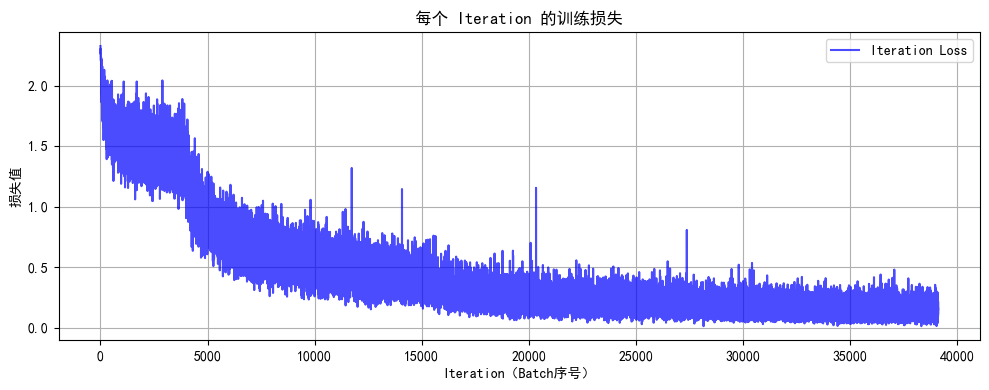

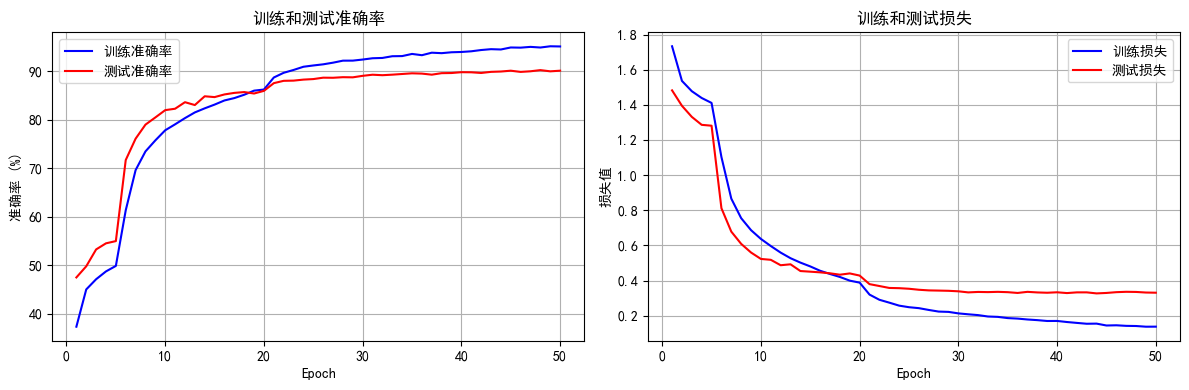

训练完成！最终测试准确率: 90.15%


In [12]:
import time

# ======================================================================
# 4. 结合了分阶段策略和详细打印的训练函数
# ======================================================================
def set_trainable_layers(model, trainable_parts):
    print(f"\n---> 解冻以下部分并设为可训练: {trainable_parts}")
    for name, param in model.named_parameters():
        param.requires_grad = False
        for part in trainable_parts:
            if part in name:
                param.requires_grad = True
                break

def train_staged_finetuning(model, criterion, train_loader, test_loader, device, epochs):
    optimizer = None
    
    # 初始化历史记录列表，与你的要求一致
    all_iter_losses, iter_indices = [], []
    train_acc_history, test_acc_history = [], []
    train_loss_history, test_loss_history = [], []

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        
        # --- 动态调整学习率和冻结层 ---
        if epoch == 1:
            print("\n" + "="*50 + "\n🚀 **阶段 1：训练注意力模块和分类头**\n" + "="*50)
            set_trainable_layers(model, ["cbam", "backbone.fc"])
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
        elif epoch == 6:
            print("\n" + "="*50 + "\n✈️ **阶段 2：解冻高层卷积层 (layer3, layer4)**\n" + "="*50)
            set_trainable_layers(model, ["cbam", "backbone.fc", "backbone.layer3", "backbone.layer4"])
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        elif epoch == 21:
            print("\n" + "="*50 + "\n🛰️ **阶段 3：解冻所有层，进行全局微调**\n" + "="*50)
            for param in model.parameters(): param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-5)
        
        # --- 训练循环 ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            # 记录每个iteration的损失
            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append((epoch - 1) * len(train_loader) + batch_idx + 1)
            
            running_loss += iter_loss
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # 按你的要求，每100个batch打印一次
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch: {epoch}/{epochs} | Batch: {batch_idx+1}/{len(train_loader)} '
                      f'| 单Batch损失: {iter_loss:.4f} | 累计平均损失: {running_loss/(batch_idx+1):.4f}')
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # --- 测试循环 ---
        model.eval()
        test_loss, correct_test, total_test = 0, 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()
        
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * correct_test / total_test
        test_loss_history.append(epoch_test_loss)
        test_acc_history.append(epoch_test_acc)
        
        # 打印每个epoch的最终结果
        print(f'Epoch {epoch}/{epochs} 完成 | 耗时: {time.time() - epoch_start_time:.2f}s | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%')
    
    # 训练结束后调用绘图函数
    print("\n训练完成! 开始绘制结果图表...")
    plot_iter_losses(all_iter_losses, iter_indices)
    plot_epoch_metrics(train_acc_history, test_acc_history, train_loss_history, test_loss_history)
    
    # 返回最终的测试准确率
    return epoch_test_acc

# ======================================================================
# 5. 绘图函数定义
# ======================================================================
def plot_iter_losses(losses, indices):
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration（Batch序号）')
    plt.ylabel('损失值')
    plt.title('每个 Iteration 的训练损失')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_epoch_metrics(train_acc, test_acc, train_loss, test_loss):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b-', label='训练准确率')
    plt.plot(epochs, test_acc, 'r-', label='测试准确率')
    plt.xlabel('Epoch')
    plt.ylabel('准确率 (%)')
    plt.title('训练和测试准确率')
    plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b-', label='训练损失')
    plt.plot(epochs, test_loss, 'r-', label='测试损失')
    plt.xlabel('Epoch')
    plt.ylabel('损失值')
    plt.title('训练和测试损失')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

# ======================================================================
# 6. 执行训练
# ======================================================================
model = ResNet18_CBAM().to(device)
criterion = nn.CrossEntropyLoss()
epochs = 50

print("开始使用带分阶段微调策略的ResNet18+CBAM模型进行训练...")
final_accuracy = train_staged_finetuning(model, criterion, train_loader, test_loader, device, epochs)
print(f"训练完成！最终测试准确率: {final_accuracy:.2f}%")

# torch.save(model.state_dict(), 'resnet18_cbam_finetuned.pth')
# print("模型已保存为: resnet18_cbam_finetuned.pth")

可以看到准确率还在持续上升，说明模型还没有收敛，对预训练模型采用cbam注意力显著增强了训练精度。

保存下目前的权重，未来可以继续训练。

In [13]:
torch.save(model.state_dict(), 'resnet18_cbam_finetuned.pth')
print("模型已保存为: resnet18_cbam_finetuned.pth")

模型已保存为: resnet18_cbam_finetuned.pth
